In [0]:
%pip install tzwhere
%pip install geopandas
%pip install pyspark_dist_explore

Python interpreter will be restarted.
  Created wheel for tzwhere: filename=tzwhere-3.0.3-py3-none-any.whl size=23742600 sha256=988efda13091c84aa7b372d67e05b077b79ae1cf3b278677ea496b8f045d66cf
  Stored in directory: /home/spark-f4cd68ec-46ac-44e1-8241-4f/.cache/pip/wheels/1c/5b/38/2c0772ba05aa51fefb242a15ed85fb649990712901b6c80458
Successfully built tzwhere
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
from pyspark.sql.functions import *
from pyspark.sql import *
from pyspark.sql.types import IntegerType, StringType
from pyspark.ml.regression import (
    LinearRegression,
    RandomForestRegressor,
    DecisionTreeRegressor,
    GBTRegressor,
)
from pyspark.ml.classification import (
    DecisionTreeClassifier,
    RandomForestClassifier,
    GBTClassifier,
    LogisticRegression,
    MultilayerPerceptronClassifier,
)
from pyspark.ml.feature import (
    VectorAssembler,
    StandardScaler,
    MinMaxScaler,
    StringIndexer,
    OneHotEncoder,
)
from pyspark.ml.stat import Correlation
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import (
    RegressionEvaluator,
    MulticlassClassificationEvaluator,
    BinaryClassificationEvaluator,
)
from pyspark.ml import Pipeline
from sklearn.metrics import roc_curve, auc
import numpy as np
import plotly
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import itertools
import re
import pytz

# from tzwhere import tzwhere
# import geopandas as gpd
# import pyspark_dist_explore as psgraph
BACKGROUND = "black"
FOREGROUND = "#73F9CB"

In [0]:
blob_container = "###"  # The name of your container created in https://portal.azure.com
storage_account = (
    "###"  # The name of your Storage account created in https://portal.azure.com
)
secret_scope = "###"  # The name of the scope created in your local computer using the Databricks CLI
secret_key = "###"  # saskey The name of the secret key created in your local computer using the Databricks CLI
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

spark.conf.set(
    f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
    dbutils.secrets.get(scope=secret_scope, key=secret_key),
)

### Classification Models

When switching to a classification task we will adjust our loss function from MSE to the categorical cross-entropy which is defined by the following relationship: 

$$Cross Entropy = -\frac{1}{M}\sum_{i=1}^{M}{y_i\log{\hat{y_i}} + (1-y_i)log(1 - \hat{y_i})}$$

In addition to the cross-entropy loss metric which will be used for the actual model training process we will also evaluate the effectiveness of our models using the precision, recall, and F1 score metrics to understand how often our model is falsely predicting a flight will be delayed (false positive) perhaps resulting in customers missing their flights because they are late to the gate thinking they had extra time vs falsely predicting a flight will not be delayed when it is (false negative) resulting in the customer spending more time waiting at the gate then necessary. 

$$Precision = \frac{TP}{TP + FP}$$

$$Recall = \frac{TP}{TP + FN} $$

$$F1_{score} = \frac{2(Recall)(Precision)}{Recall + Precision}$$

### New features

In [0]:
feature_columns = [
    "delays_last_4hrs",
    "fraction_delayed_last_4hrs",
    "inbound_dep_delay_time",
    "volume_sigma",
    "origin_weather_Avg_HourlyRelativeHumidity",
    "dest_weather_Avg_HourlyRelativeHumidity",
    "origin_weather_NonZero_Rain",
    "dest_weather_NonZero_Rain",
    "origin_weather_Present_Weather_Rain",
    "origin_weather_Trace_Rain",
    "origin_weather_Sky_Conditions_OVC",
    "origin_weather_Present_Weather_Storm",
    "origin_weather_Present_Weather_Mist",
    "dest_weather_Present_Weather_Rain",
    "origin_weather_Avg_HourlyAltimeterSetting",
    "origin_weather_Avg_HourlySeaLevelPressure",
    "dest_weather_Avg_HourlyAltimeterSetting",
    "dest_weather_Avg_HourlySeaLevelPressure",
    "origin_weather_Avg_HourlyVisibility",
]

In [0]:
data_undersample = spark.read.parquet(
    f"{blob_url}/final_data_phase4_3b_Dec_undersample"
)

In [0]:
data_oversample = spark.read.parquet(f"{blob_url}/final_data_phase4_3b_Dec_oversample")

###Training pipeline

In [0]:
def parameter_combinations(parameter_dict):
    parameter_list = list(parameter_dict.keys())
    return (parameter_list, list(itertools.product(*parameter_dict.values())))

#### Main function

In [0]:
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.MulticlassClassificationEvaluator.html
# MulticlassClassificationEvaluator
def TimeSeriesCrossValidatorClassifier(
    input_data, feature_columns, label_column, pipeline_type, parameter_combinations
):
    """Expects a dictionary where each key is a fold and value is a dataframe of training/test data with training/test rows identified by a column called 'cv'."""
    if pipeline_type == "GradientBoosted_classification":
        print(f"Running {pipeline_type}")
        pipe_path = GradientBoosted_classification_pipeline

    elif pipeline_type == "decision_tree_binary_classification":
        print(f"Running {pipeline_type}")
        pipe_path = decision_tree_binary_classification_pipeline

    elif pipeline_type == "random_forest_classification":
        print(f"Running {pipeline_type}")
        pipe_path = random_forest_classification_pipeline

    elif pipeline_type == "logistic_regression":
        print(f"Running {pipeline_type}")
        pipe_path = LogisticRegression_pipeline

    elif pipeline_type == "MLP":
        print(f"Running {pipeline_type}")
        pipe_path = MLP_pipeline

    parameter_names = parameter_combinations[0]
    parameter_values = parameter_combinations[1]
    best_parameters = None
    highest_areaUnderROC = None

    model = None
    areaUnderPR_kept = None
    # f1_kept = None
    # weightedPrecision_kept = None
    # weightedRecall_kept = None

    for parameters in parameter_values:
        pipeline = pipe_path(feature_columns, label_column, parameters)
        fold_areaUnderROC = []
        fold_areaUnderPR = []
        for fold in input_data.keys():
            train_data = input_data[fold].filter(col("cv") == "train")
            test_data = input_data[fold].filter(col("cv") == "test")
            model = pipeline.fit(train_data)

            predictions = model.transform(test_data)

            evaluator = BinaryClassificationEvaluator(
                labelCol=label_column
            )  # BinaryClassificationEvaluator
            areaUnderPR = evaluator.evaluate(
                predictions, {evaluator.metricName: "areaUnderPR"}
            )
            areaUnderROC = evaluator.evaluate(
                predictions, {evaluator.metricName: "areaUnderROC"}
            )

            # evaluator = MulticlassClassificationEvaluator(labelCol = label_column) #BinaryClassificationEvaluator
            # accuracy = evaluator.evaluate(predictions, {evaluator.metricName:'accuracy'})
            # f1 = evaluator.evaluate(predictions, {evaluator.metricName:'f1'})
            # weightedPrecision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"}) #maybe not weighted
            # weightedRecall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"}) #maybe not weighted

            # truePositiveRateByLabel = evaluator.evaluate(predictions, {evaluator.metricName:'truePositiveRateByLabel'})

            fold_areaUnderROC.append(areaUnderROC)
            fold_areaUnderPR.append(areaUnderPR)
            print(f"{fold}: {areaUnderROC}")

        mean_areaUnderROC = np.mean(fold_areaUnderROC)
        mean_areaUnderPR = np.mean(fold_areaUnderPR)
        if not highest_areaUnderROC:
            highest_areaUnderROC = mean_areaUnderROC

            model_kept = model
            areaUnderPR_kept = mean_areaUnderPR
            # f1_kept = f1
            # weightedPrecision_kept = weightedPrecision
            # weightedRecall_kept = weightedRecall

        if mean_areaUnderROC >= highest_areaUnderROC:
            highest_areaUnderROC = mean_areaUnderROC
            areaUnderPR_kept = mean_areaUnderPR
            # f1_kept = f1
            # weightedPrecision_kept = weightedPrecision
            # weightedRecall_kept = weightedRecall

            best_parameters = parameters
            parameter_string = {
                parameter_names[ii]: parameters[ii]
                for ii in range(len(parameter_names))
            }
            print(
                f"highest_accuracy: {highest_areaUnderROC}\nParmeters:{parameter_string}"
            )
    return (
        best_parameters,
        highest_areaUnderROC,
        areaUnderPR_kept,
    )  # ,f1_kept, weightedPrecision_kept, weightedRecall_kept, model_kept  #add f1,wheightedPrecision and recall

####_Multilayer perceptron classifier
Ref: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.MultilayerPerceptronClassifier.html

In [0]:
def MLP_pipeline(feature_columns, label_column, parameters):
    # string_indexer = StringIndexer(inputCol='origin', outputCol='aiport_index')

    #   one_hot_encode = OneHotEncoder(inputCol='aiport_index', outputCol= "aiport_one")
    feature_vector_assembler = VectorAssembler(
        inputCols=feature_columns, outputCol="features"
    )
    #   data_scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')
    # dt_regressor = DecisionTreeClassifier(featuresCol='features', labelCol='dep_delay_group', maxDepth=parameters[0], maxBins=parameters[1])

    # dt_regressor = DecisionTreeClassifier(featuresCol='features', labelCol='DEP_DEL15', maxDepth=parameters[0], maxBins=parameters[1])

    mlp_classifier = MultilayerPerceptronClassifier(
        featuresCol="features",
        labelCol="DEP_DEL15",
        maxIter=300,
        layers=parameters[0],
        blockSize=parameters[1],
        solver=parameters[2],
        stepSize=parameters[3],
        seed=1234,
    )

    pipeline = Pipeline(stages=[feature_vector_assembler, mlp_classifier])
    return pipeline

###Evaluation pipeline

####_main function

In [0]:
def evaluate_testSet(
    train_data, test_data, feature_columns, label_column, model_type, parameters
):
    """This function would evaluate the test data using the best parameters obtained from
    the time series cross validation.
    """
    print(f"Begin fitting pipeline on train dataset to create {model_type} model")
    if model_type == "GradientBoosted_classification":
        pipeline = GradientBoosted_classification_pipeline(
            feature_columns, label_column, parameters
        )

    elif model_type == "decision_tree_binary_classification":
        pipeline = decision_tree_binary_classification_pipeline(
            feature_columns, label_column, parameters
        )

    elif model_type == "random_forest_classification":
        pipeline = random_forest_classification_pipeline(
            feature_columns, label_column, parameters
        )
    elif model_type == "logistic_regression":
        pipeline = LogisticRegression_pipeline(
            feature_columns, label_column, parameters
        )
    elif model_type == "MLP":
        pipeline = MLP_pipeline(feature_columns, label_column, parameters)

    model = pipeline.fit(train_data)

    print(
        "pipeline fit has been completed on the train data! Let's begin model transformation on the test data."
    )
    predictions = model.transform(test_data)

    print("Model transformation on test data completed! Now begin evaluation.")
    evaluator = BinaryClassificationEvaluator(labelCol=label_column)
    areaUnderROC = evaluator.evaluate(
        predictions, {evaluator.metricName: "areaUnderROC"}
    )
    areaUnderPR = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
    # f1 = evaluator.evaluate(predictions, {evaluator.metricName:'f1'})
    # weightedPrecision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"}) #maybe not weighted
    # weightedRecall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"}) #maybe not weighted

    print("Evaluation completed!")
    print(f"Evaluation results for {model_type} are: ")
    print(
        f"areaUnderROC: {areaUnderROC}, areaUnderPR: {areaUnderPR}"
    )  # , f1: {f1}, weighted precision: {weightedPrecision}, weighted recall: {weightedRecall}
    return model, predictions, evaluator

####_visualization of results

In [0]:
# ROC curve
def plotting_function(DS_predictions):
    # code from https://github.com/elsyifa/Classification-Pyspark
    PredAndLabels = DS_predictions.select("probability", "DEP_DEL15")
    PredAndLabels_collect = PredAndLabels.collect()
    PredAndLabels_list = [
        (float(i[0][0]), 1.0 - float(i[1])) for i in PredAndLabels_collect
    ]
    PredAndLabels = sc.parallelize(PredAndLabels_list)

    # Visualization
    FPR = dict()  # FPR: False Positive Rate
    tpr = dict()  # TPR: True Positive Rate
    roc_auc = dict()

    y_test = [i[1] for i in PredAndLabels_list]
    y_score = [i[0] for i in PredAndLabels_list]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    return plt.show()

In [0]:
# confusion matrix
def confusion_matrix(DS_predictions):
    cm_dt_result = DS_predictions.crosstab("prediction", "DEP_DEL15")
    cm_dt_result = cm_dt_result.toPandas()
    return cm_dt_result


"""
def confusion_matrix_pourcentage(DS_predictions):
    cm_dt_result = DS_predictions.crosstab("prediction", "DEP_DEL15", normalize=True)
    cm_dt_result = cm_dt_result.toPandas()
    return cm_dt_result
"""

Out[12]: '\ndef confusion_matrix_pourcentage(DS_predictions):\n    cm_dt_result = DS_predictions.crosstab("prediction", "DEP_DEL15", normalize=True)\n    cm_dt_result = cm_dt_result.toPandas()\n    return cm_dt_result\n'

###Training on undersampled data

)

In [0]:
data = data_undersample

In [0]:
# Split the joined data frame into year chunks to allow concatenating them as blocks as shown visually in the image above.
# The custom-cross validator is expecting a dictionary where each key is a different fold, and the key value is a dataframe with a column called 'cv' that designates rows
# As either train or split

series_folds = {
    "fold1": (["2015", "2016"], ["2017", "2018"]),
    "fold2": (["2015", "2016", "2017"], ["2018", "2019"]),
    "fold3": (["2015", "2016", "2017", "2018"], ["2019", "2020"]),
}
cross_validation_data = {}
for fold in series_folds.keys():
    train_years = series_folds[fold][0]
    val_years = series_folds[fold][1]
    cross_validation_data[fold] = (
        data.filter(data.YEAR.isin(train_years + val_years))
        .withColumn(
            "cv", when(col("YEAR").isin(train_years), "train").otherwise("test")
        )
        .cache()
    )

####_Multilayer perceptron classifier

#### Experiment 1

In [0]:
MLP_parameters = {
    "layers": [[19, 38, 2]],
    "blockSize": [128],
    "solver": ["gd"],
    "stepSize": [0.03],
}

MLP_param_combos = parameter_combinations(MLP_parameters)
MLP_results = TimeSeriesCrossValidatorClassifier(
    cross_validation_data, feature_columns, "DEP_DEL15", "MLP", MLP_param_combos
)
print(
    f"Multilayer Perceptron best params: {MLP_results[0]}, areaUnderROC: {MLP_results[1]},areaUnderPR: {MLP_results[2]} "
)

Running MLP
fold1: 0.6882541391925122
fold2: 0.6885963163886424
fold3: 0.6863132273640609
highest_accuracy: 0.6877212276484052
Parmeters:{'layers': [19, 38, 2], 'blockSize': 128, 'solver': 'gd', 'stepSize': 0.03}
Multilayer Perceptron best params: ([19, 38, 2], 128, 'gd', 0.03), areaUnderROC: 0.6877212276484052,areaUnderPR: 0.6625444503998029 


###Evaluation on test data

In [0]:
label_column = "DEP_DEL15"
train_data = data.filter((col("year")) < "2021")
test_data = data.filter((col("year")) == "2021")

In [0]:
# MLP
parameters = list(MLP_results[0])
model_type = "MLP"
us_MLP_model, us_MLP_predictions, us_MLP_evaluator = evaluate_testSet(
    train_data, test_data, feature_columns, label_column, model_type, parameters
)
us_MLP_predictions.write.parquet(
    f"{blob_url}/test_on_eval_data/us_MLP_prediction_expt1_12-06"
)

Begin fitting pipeline on train dataset to create MLP model
pipeline fit has been completed on the train data! Let's begin model transformation on the test data.
Model transformation on test data completed! Now begin evaluation.
Evaluation completed!
Evaluation results for MLP are: 
areaUnderROC: 0.6698998898260766, areaUnderPR: 0.6443667766325035


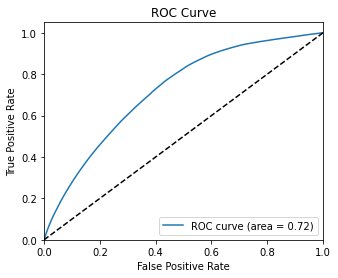

,prediction_DEP_DEL15,0.0,1.0
0,1.0,150928,425908
1,0.0,972953,521803


In [0]:
DS_predictions = spark.read.parquet(
    f"{blob_url}/test_on_eval_data/us_MLP_prediction_expt1_12-06"
)
plotting_function(DS_predictions)
confusion_matrix(DS_predictions)

#### Experiment 2

In [0]:
# Expt2
MLP_parameters = {
    "layers": [[19, 38, 10, 2]],
    "blockSize": [128],
    "solver": ["gd"],
    "stepSize": [0.03],
}

MLP_param_combos = parameter_combinations(MLP_parameters)
MLP_results = TimeSeriesCrossValidatorClassifier(
    cross_validation_data, feature_columns, "DEP_DEL15", "MLP", MLP_param_combos
)
print(
    f"Multilayer Perceptron best params: {MLP_results[0]}, areaUnderROC: {MLP_results[1]},areaUnderPR: {MLP_results[2]} "
)

Running MLP
fold1: 0.666242057373095
fold2: 0.6677025548697588
fold3: 0.658810964881784
highest_accuracy: 0.664251859041546
Parmeters:{'layers': [19, 38, 10, 2], 'blockSize': 128, 'solver': 'gd', 'stepSize': 0.03}
Multilayer Perceptron best params: ([19, 38, 10, 2], 128, 'gd', 0.03), areaUnderROC: 0.664251859041546,areaUnderPR: 0.6327703706121218 


In [0]:
# Evaluation on test data
parameters = list(MLP_results[0])
model_type = "MLP"
us_MLP_model, us_MLP_predictions, us_MLP_evaluator = evaluate_testSet(
    train_data, test_data, feature_columns, label_column, model_type, parameters
)
us_MLP_predictions.write.parquet(
    f"{blob_url}/test_on_eval_data/us_MLP_prediction_expt2_12-06"
)

Begin fitting pipeline on train dataset to create MLP model
pipeline fit has been completed on the train data! Let's begin model transformation on the test data.
Model transformation on test data completed! Now begin evaluation.
Evaluation completed!
Evaluation results for MLP are: 
areaUnderROC: 0.6443442585044207, areaUnderPR: 0.6128460337709839


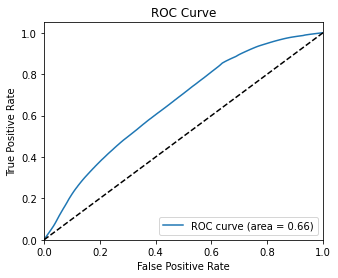

,prediction_DEP_DEL15,0.0,1.0
0,1.0,109733,273630
1,0.0,1014148,674081


In [0]:
DS_predictions = spark.read.parquet(
    f"{blob_url}/test_on_eval_data/us_MLP_prediction_expt2_12-06"
)
plotting_function(DS_predictions)
confusion_matrix(DS_predictions)

#### Experiment 3

In [0]:
MLP_parameters = {
    "layers": [[19, 39, 19, 7, 2]],
    "blockSize": [128],
    "solver": ["gd"],
    "stepSize": [0.03],
}

MLP_param_combos = parameter_combinations(MLP_parameters)
MLP_results = TimeSeriesCrossValidatorClassifier(
    cross_validation_data, feature_columns, "DEP_DEL15", "MLP", MLP_param_combos
)
print(
    f"Multilayer Perceptron best params: {MLP_results[0]}, areaUnderROC: {MLP_results[1]},areaUnderPR: {MLP_results[2]} "
)

Running MLP
fold1: 0.4870662591604741
fold2: 0.4898085613145498
fold3: 0.49305416327287493
highest_accuracy: 0.4899763279159663
Parmeters:{'layers': [19, 39, 19, 7, 2], 'blockSize': 128, 'solver': 'gd', 'stepSize': 0.03}
Multilayer Perceptron best params: ([19, 39, 19, 7, 2], 128, 'gd', 0.03), areaUnderROC: 0.4899763279159663,areaUnderPR: 0.45479989045882757 


In [0]:
# Evaluation on test data
parameters = list(MLP_results[0])
model_type = "MLP"
us_MLP_model, us_MLP_predictions, us_MLP_evaluator = evaluate_testSet(
    train_data, test_data, feature_columns, label_column, model_type, parameters
)
us_MLP_predictions.write.parquet(
    f"{blob_url}/test_on_eval_data/us_MLP_prediction_expt3_12-06"
)

Begin fitting pipeline on train dataset to create MLP model
pipeline fit has been completed on the train data! Let's begin model transformation on the test data.
Model transformation on test data completed! Now begin evaluation.
Evaluation completed!
Evaluation results for MLP are: 
areaUnderROC: 0.47466527704931943, areaUnderPR: 0.4387643991189947


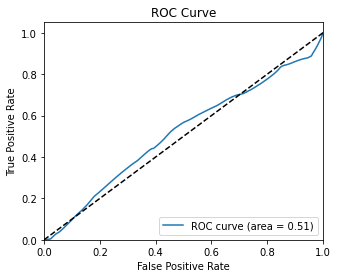

,prediction_DEP_DEL15,0.0,1.0
0,0.0,1123881,947711


In [0]:
DS_predictions = spark.read.parquet(
    f"{blob_url}/test_on_eval_data/us_MLP_prediction_expt3_12-06"
)
plotting_function(DS_predictions)
confusion_matrix(DS_predictions)

#### Experiment 4

In [0]:
MLP_parameters = {
    "layers": [[19, 38, 2]],
    "blockSize": [128],
    "solver": ["l-bfgs"],
    "stepSize": [0.03],
}

MLP_param_combos = parameter_combinations(MLP_parameters)
MLP_results = TimeSeriesCrossValidatorClassifier(
    cross_validation_data, feature_columns, "DEP_DEL15", "MLP", MLP_param_combos
)
print(
    f"Multilayer Perceptron best params: {MLP_results[0]}, areaUnderROC: {MLP_results[1]},areaUnderPR: {MLP_results[2]} "
)

Running MLP
fold1: 0.7914135061421128
fold2: 0.7849055182920587
fold3: 0.7862298321744784
highest_accuracy: 0.7875162855362166
Parmeters:{'layers': [19, 38, 2], 'blockSize': 128, 'solver': 'l-bfgs', 'stepSize': 0.03}
Multilayer Perceptron best params: ([19, 38, 2], 128, 'l-bfgs', 0.03), areaUnderROC: 0.7875162855362166,areaUnderPR: 0.7608208903751085 


In [0]:
# Evaluation on test data
parameters = list(MLP_results[0])
model_type = "MLP"
us_MLP_model, us_MLP_predictions, us_MLP_evaluator = evaluate_testSet(
    train_data, test_data, feature_columns, label_column, model_type, parameters
)
us_MLP_predictions.write.parquet(
    f"{blob_url}/test_on_eval_data/us_MLP_prediction_expt4_12-06"
)

Begin fitting pipeline on train dataset to create MLP model
pipeline fit has been completed on the train data! Let's begin model transformation on the test data.
Model transformation on test data completed! Now begin evaluation.
Evaluation completed!
Evaluation results for MLP are: 
areaUnderROC: 0.7779781746599286, areaUnderPR: 0.7436071613384815


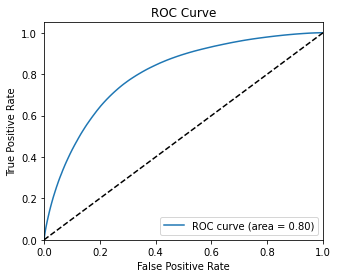

,prediction_DEP_DEL15,0.0,1.0
0,1.0,217306,619205
1,0.0,906575,328506


In [0]:
DS_predictions = spark.read.parquet(
    f"{blob_url}/test_on_eval_data/us_MLP_prediction_expt4_12-06"
)
plotting_function(DS_predictions)
confusion_matrix(DS_predictions)

#### Experiment 5

In [0]:
MLP_parameters = {
    "layers": [[19, 38, 2]],
    "blockSize": [128],
    "solver": ["l-bfgs"],
    "stepSize": [0.03],
}

MLP_param_combos = parameter_combinations(MLP_parameters)
MLP_results = TimeSeriesCrossValidatorClassifier(
    cross_validation_data, feature_columns, "DEP_DEL15", "MLP", MLP_param_combos
)
print(
    f"Multilayer Perceptron best params: {MLP_results[0]}, areaUnderROC: {MLP_results[1]},areaUnderPR: {MLP_results[2]} "
)

Running MLP
fold1: 0.7347824529956296
fold2: 0.7244202635914427
fold3: 0.7524972714577693
highest_accuracy: 0.7372333293482806
Parmeters:{'layers': [19, 38, 2], 'blockSize': 128, 'solver': 'l-bfgs', 'stepSize': 0.03}
Multilayer Perceptron best params: ([19, 38, 2], 128, 'l-bfgs', 0.03), areaUnderROC: 0.7372333293482806,areaUnderPR: 0.6988080930465789 


In [0]:
# Evaluation on test data
parameters = list(MLP_results[0])
model_type = "MLP"
us_MLP_model, us_MLP_predictions, us_MLP_evaluator = evaluate_testSet(
    train_data, test_data, feature_columns, label_column, model_type, parameters
)
us_MLP_predictions.write.parquet(
    f"{blob_url}/test_on_eval_data/us_MLP_prediction_expt5_12-06"
)

Begin fitting pipeline on train dataset to create MLP model
pipeline fit has been completed on the train data! Let's begin model transformation on the test data.
Model transformation on test data completed! Now begin evaluation.
Evaluation completed!
Evaluation results for MLP are: 
areaUnderROC: 0.7188254648528795, areaUnderPR: 0.6808218540408684


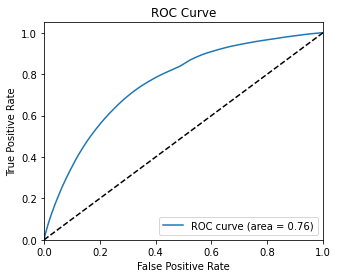

,prediction_DEP_DEL15,0.0,1.0
0,1.0,180593,485228
1,0.0,943288,462483


In [0]:
DS_predictions = spark.read.parquet(
    f"{blob_url}/test_on_eval_data/us_MLP_prediction_expt5_12-06"
)
plotting_function(DS_predictions)
confusion_matrix(DS_predictions)

#### Experiment 6

In [0]:
# maxIter = 150
MLP_parameters = {
    "layers": [[19, 38, 2]],
    "blockSize": [128],
    "solver": ["l-bfgs"],
    "stepSize": [0.03],
}

MLP_param_combos = parameter_combinations(MLP_parameters)
MLP_results = TimeSeriesCrossValidatorClassifier(
    cross_validation_data, feature_columns, "DEP_DEL15", "MLP", MLP_param_combos
)
print(
    f"Multilayer Perceptron best params: {MLP_results[0]}, areaUnderROC: {MLP_results[1]},areaUnderPR: {MLP_results[2]} "
)

Running MLP
fold1: 0.82320297887553
fold2: 0.823827462789831
fold3: 0.8344529230049825
highest_accuracy: 0.8271611215567812
Parmeters:{'layers': [19, 38, 2], 'blockSize': 128, 'solver': 'l-bfgs', 'stepSize': 0.03}
Multilayer Perceptron best params: ([19, 38, 2], 128, 'l-bfgs', 0.03), areaUnderROC: 0.8271611215567812,areaUnderPR: 0.7930342453029785 


In [0]:
# Evaluation on test data
parameters = list(MLP_results[0])
model_type = "MLP"
us_MLP_model, us_MLP_predictions, us_MLP_evaluator = evaluate_testSet(
    train_data, test_data, feature_columns, label_column, model_type, parameters
)
us_MLP_predictions.write.parquet(
    f"{blob_url}/test_on_eval_data/us_MLP_prediction_expt6_12-06"
)

Begin fitting pipeline on train dataset to create MLP model
pipeline fit has been completed on the train data! Let's begin model transformation on the test data.
Model transformation on test data completed! Now begin evaluation.
Evaluation completed!
Evaluation results for MLP are: 
areaUnderROC: 0.8353183903962315, areaUnderPR: 0.7970679758038657


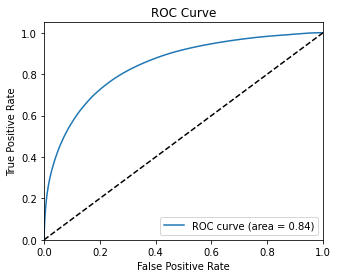

,prediction_DEP_DEL15,0.0,1.0
0,1.0,227595,687779
1,0.0,896286,259932


In [0]:
DS_predictions = spark.read.parquet(
    f"{blob_url}/test_on_eval_data/us_MLP_prediction_expt6_12-06"
)
plotting_function(DS_predictions)
confusion_matrix(DS_predictions)

#### Experiment 7

In [0]:
# maxIter = 200
MLP_parameters = {
    "layers": [[19, 38, 2]],
    "blockSize": [128],
    "solver": ["l-bfgs"],
    "stepSize": [0.03],
}

MLP_param_combos = parameter_combinations(MLP_parameters)
MLP_results = TimeSeriesCrossValidatorClassifier(
    cross_validation_data, feature_columns, "DEP_DEL15", "MLP", MLP_param_combos
)
print(
    f"Multilayer Perceptron best params: {MLP_results[0]}, areaUnderROC: {MLP_results[1]},areaUnderPR: {MLP_results[2]} "
)

Running MLP
fold1: 0.8305502834789168
fold2: 0.8314049522168087
fold3: 0.8451457356044464
highest_accuracy: 0.8357003237667239
Parmeters:{'layers': [19, 38, 2], 'blockSize': 128, 'solver': 'l-bfgs', 'stepSize': 0.03}
Multilayer Perceptron best params: ([19, 38, 2], 128, 'l-bfgs', 0.03), areaUnderROC: 0.8357003237667239,areaUnderPR: 0.7982329179099147 


In [0]:
# Evaluation on test data
parameters = list(MLP_results[0])
model_type = "MLP"
us_MLP_model, us_MLP_predictions, us_MLP_evaluator = evaluate_testSet(
    train_data, test_data, feature_columns, label_column, model_type, parameters
)
us_MLP_predictions.write.parquet(
    f"{blob_url}/test_on_eval_data/us_MLP_prediction_expt7_12-06"
)

Begin fitting pipeline on train dataset to create MLP model
pipeline fit has been completed on the train data! Let's begin model transformation on the test data.
Model transformation on test data completed! Now begin evaluation.
Evaluation completed!
Evaluation results for MLP are: 
areaUnderROC: 0.8315719802726007, areaUnderPR: 0.7953768009659756


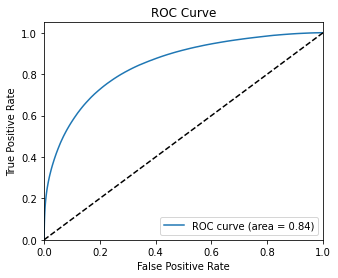

,prediction_DEP_DEL15,0.0,1.0
0,1.0,243943,704424
1,0.0,879938,243287


In [0]:
DS_predictions = spark.read.parquet(
    f"{blob_url}/test_on_eval_data/us_MLP_prediction_expt7_12-06"
)
plotting_function(DS_predictions)
confusion_matrix(DS_predictions)

#### Experiment 8

In [0]:
# maxIter = 300
MLP_parameters = {
    "layers": [[19, 38, 2]],
    "blockSize": [128],
    "solver": ["l-bfgs"],
    "stepSize": [0.03],
}

MLP_param_combos = parameter_combinations(MLP_parameters)
MLP_results = TimeSeriesCrossValidatorClassifier(
    cross_validation_data, feature_columns, "DEP_DEL15", "MLP", MLP_param_combos
)
print(
    f"Multilayer Perceptron best params: {MLP_results[0]}, areaUnderROC: {MLP_results[1]},areaUnderPR: {MLP_results[2]} "
)

Running MLP
fold1: 0.8392110274652637
fold2: 0.8377998978275942
fold3: 0.8489060812086698
highest_accuracy: 0.8419723355005093
Parmeters:{'layers': [19, 38, 2], 'blockSize': 128, 'solver': 'l-bfgs', 'stepSize': 0.03}
Multilayer Perceptron best params: ([19, 38, 2], 128, 'l-bfgs', 0.03), areaUnderROC: 0.8419723355005093,areaUnderPR: 0.8065834775262691 


In [0]:
# Evaluation on test data
parameters = list(MLP_results[0])
model_type = "MLP"
us_MLP_model, us_MLP_predictions, us_MLP_evaluator = evaluate_testSet(
    train_data, test_data, feature_columns, label_column, model_type, parameters
)
us_MLP_predictions.write.parquet(
    f"{blob_url}/test_on_eval_data/us_MLP_prediction_expt8_12-06"
)

Begin fitting pipeline on train dataset to create MLP model
pipeline fit has been completed on the train data! Let's begin model transformation on the test data.
Model transformation on test data completed! Now begin evaluation.
Evaluation completed!
Evaluation results for MLP are: 
areaUnderROC: 0.8395500515605991, areaUnderPR: 0.8060126704347288


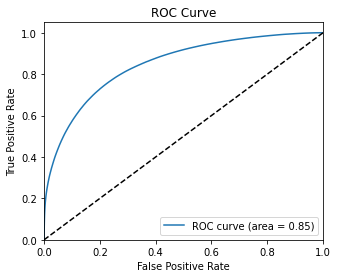

,prediction_DEP_DEL15,0.0,1.0
0,1.0,238201,700992
1,0.0,885680,246719


In [0]:
DS_predictions = spark.read.parquet(
    f"{blob_url}/test_on_eval_data/us_MLP_prediction_expt8_12-06"
)
plotting_function(DS_predictions)
confusion_matrix(DS_predictions)

### Plot training(validation) curves by epoch

In [0]:
# Let's plot the areaUnderROC for the validation results obtained during training.
details = {
    "validation_areaUnderROC": [0.737, 0.787, 0.827, 0.836, 0.842],
    "MaxIter(Epochs)": [50, 100, 150, 200, 300],
}

# creating a Dataframe object
training_curves_by_epoch = pd.DataFrame(details)
training_curves_by_epoch

,validation_areaUnderROC,MaxIter(Epochs)
0,0.737,50
1,0.787,100
2,0.827,150
3,0.836,200
4,0.842,300


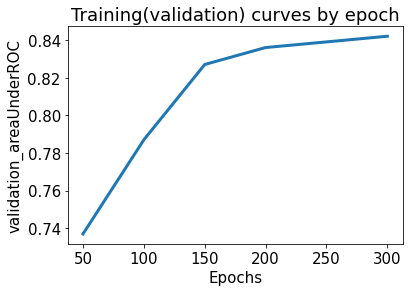

In [0]:
# Define function to plot training loss
plt.rcParams.update({"font.size": 15})


def plot_curve(num_epochs, model_loss):

    plt.plot(x, y, linewidth=3)
    plt.xlabel("Epochs")
    plt.ylabel("validation_areaUnderROC")
    plt.title("Training(validation) curves by epoch")
    plt.show()


x = training_curves_by_epoch["MaxIter(Epochs)"]
y = training_curves_by_epoch["validation_areaUnderROC"]
plot_curve(x, y)